<a href="https://www.kaggle.com/code/a7medragab11/cats-dogs-classification-using-vgg16?scriptVersionId=249314972" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import cv2
import pickle

2025-07-08 00:48:27.342535: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751935707.711689      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751935707.820181      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 12
DATADIR = "/kaggle/input/dog-and-cat-classification-dataset/PetImages"
CATEGORIES = ["Dog", "Cat"]

In [3]:
MAX_IMAGES_PER_CLASS = 3000  # <= for memory limit

all_data = []

def get_all_data():
    for class_num, category in enumerate(CATEGORIES):
        path = os.path.join(DATADIR, category)
        loaded = 0

        for img in tqdm(os.listdir(path), desc=f"Loading {category}"):
            if loaded >= MAX_IMAGES_PER_CLASS:
                break  # stop early to reduce memory

            try:
                img_path = os.path.join(path, img)
                img_array = cv2.imread(img_path)
                if img_array is None:
                    continue

                resized_array = cv2.resize(img_array, IMG_SIZE)
                all_data.append([resized_array, class_num])
                loaded += 1

            except Exception as e:
                continue  # skip corrupted or unreadable images

        print(f"Loaded {loaded} images for category '{category}'")

get_all_data()


Loading Dog:  24%|██▍       | 3006/12499 [00:21<01:08, 139.42it/s]


Loaded 3000 images for category 'Dog'


Loading Cat:  24%|██▍       | 3004/12499 [00:19<01:03, 150.24it/s]

Loaded 3000 images for category 'Cat'


## delete saved file

In [4]:
# os.remove("/kaggle/working/all_data.pickle")
# os.remove("/kaggle/working/X.pickle")
# os.remove("/kaggle/working/y.pickle")

## saving all_data

In [5]:
# # Save X
# with open("all_data.pickle", "wb") as f:
#     pickle.dump(all_data, f)

## loading all_data values

In [6]:
# with open("/kaggle/working/all_data.pickle", "rb") as f:
#     all_data = pickle.load(f)

In [7]:
all_data[0]

[array([[[116, 144, 205],
         [122, 151, 212],
         [114, 147, 208],
         ...,
         [ 28,  75, 149],
         [ 29,  77, 149],
         [ 29,  77, 149]],
 
        [[115, 142, 204],
         [119, 149, 209],
         [114, 146, 207],
         ...,
         [ 32,  79, 153],
         [ 32,  80, 152],
         [ 32,  80, 152]],
 
        [[ 99, 125, 186],
         [100, 128, 188],
         [100, 129, 189],
         ...,
         [ 31,  79, 152],
         [ 31,  79, 150],
         [ 31,  79, 150]],
 
        ...,
 
        [[153, 171, 208],
         [148, 164, 204],
         [153, 169, 213],
         ...,
         [139, 183, 204],
         [151, 189, 213],
         [140, 176, 200]],
 
        [[163, 179, 221],
         [140, 155, 200],
         [133, 147, 195],
         ...,
         [120, 160, 178],
         [132, 169, 191],
         [136, 170, 193]],
 
        [[149, 163, 210],
         [138, 151, 201],
         [120, 132, 186],
         ...,
         [121, 157, 170],
  

## shuffle the data

In [8]:
random.shuffle(all_data)

## Convert to NumPy arrays

In [9]:
X_L = []
y_L = []

for features, label in all_data:
    X_L.append(features)
    y_L.append(label)

# Convert to NumPy arrays
X = np.array(X_L)  # (224, 224, 3)
y = np.array(y_L)

## show random image

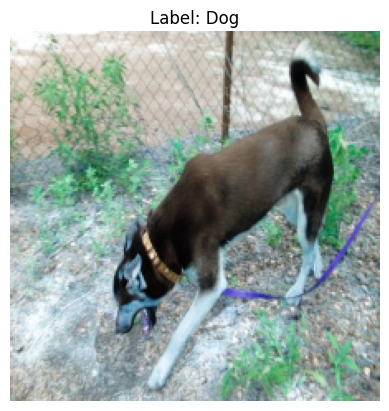

In [10]:
ran = random.randint(0, len(X) - 1)
plt.imshow(X[ran])
plt.title(f"Label: {CATEGORIES[y[ran]]}")
plt.axis('off')
plt.show()

## Save X , Y array values

In [11]:
# # Save X
# with open("X.pickle", "wb") as f:
#     pickle.dump(X, f)

# # Save y
# with open("y.pickle", "wb") as f:
#     pickle.dump(y, f)

## loading X , Y array value

In [12]:
# # Load X
# with open("X.pickle", "rb") as f:
#     X = pickle.load(f)

# # Load y
# with open("y.pickle", "rb") as f:
#     y = pickle.load(f)

## Normalization

In [13]:
X = X.astype("float32") / 255.0 

In [14]:
X[0]

array([[[0.49019608, 0.5411765 , 0.60784316],
        [0.4117647 , 0.4627451 , 0.5254902 ],
        [0.42352942, 0.47843137, 0.5411765 ],
        ...,
        [0.40392157, 0.47843137, 0.50980395],
        [0.41568628, 0.47843137, 0.5294118 ],
        [0.43137255, 0.49019608, 0.5529412 ]],

       [[0.4745098 , 0.5294118 , 0.5882353 ],
        [0.40784314, 0.45882353, 0.5176471 ],
        [0.41960785, 0.47058824, 0.53333336],
        ...,
        [0.39215687, 0.4627451 , 0.5058824 ],
        [0.4       , 0.4627451 , 0.5176471 ],
        [0.41960785, 0.48235294, 0.5411765 ]],

       [[0.47058824, 0.52156866, 0.58431375],
        [0.40392157, 0.45490196, 0.5176471 ],
        [0.41568628, 0.47058824, 0.53333336],
        ...,
        [0.4       , 0.47843137, 0.52156866],
        [0.4117647 , 0.47058824, 0.5372549 ],
        [0.43529412, 0.49411765, 0.5568628 ]],

       ...,

       [[0.4       , 0.5019608 , 0.64705884],
        [0.31764707, 0.43137255, 0.58431375],
        [0.30980393, 0

## split data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

In [16]:
X_train.shape

(5400, 224, 224, 3)

In [17]:
y_train.shape

(5400,)

In [18]:
X_test.shape

(600, 224, 224, 3)

In [19]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_base.trainable = False  # freeze pretrained layers

I0000 00:00:1751935771.888992      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751935771.889679      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Built the model

In [20]:
model = Sequential([
    vgg_base,
    Flatten(),
    # Dense(256, activation='relu'),
    # Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary class
])

In [21]:
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          25,089 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,739,777 (56.23 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [23]:
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=12,
    validation_split=0.1
)

Epoch 1/12


I0000 00:00:1751935783.515071      65 service.cc:148] XLA service 0x7c7e6c006f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751935783.516642      65 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751935783.516664      65 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751935783.938854      65 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/152 ━━━━━━━━━━━━━━━━━━━━ 33:37 13s/step - accuracy: 0.4062 - loss: 0.7723

I0000 00:00:1751935795.154214      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


152/152 ━━━━━━━━━━━━━━━━━━━━ 55s 277ms/step - accuracy: 0.7169 - loss: 0.5617 - val_accuracy: 0.8944 - val_loss: 0.3060
Epoch 2/12
152/152 ━━━━━━━━━━━━━━━━━━━━ 34s 222ms/step - accuracy: 0.9050 - loss: 0.2907 - val_accuracy: 0.9111 - val_loss: 0.2412
Epoch 3/12
152/152 ━━━━━━━━━━━━━━━━━━━━ 35s 231ms/step - accuracy: 0.9218 - loss: 0.2334 - val_accuracy: 0.9148 - val_loss: 0.2136
Epoch 4/12
152/152 ━━━━━━━━━━━━━━━━━━━━ 34s 223ms/step - accuracy: 0.9305 - loss: 0.2051 - val_accuracy: 0.9148 - val_loss: 0.1964
Epoch 5/12
152/152 ━━━━━━━━━━━━━━━━━━━━ 34s 225ms/step - accuracy: 0.9552 - loss: 0.1725 - val_accuracy: 0.9278 - val_loss: 0.1869
Epoch 6/12
152/152 ━━━━━━━━━━━━━━━━━━━━ 34s 225ms/step - accuracy: 0.9491 - loss: 0.1637 - val_accuracy: 0.9130 - val_loss: 0.1794
Epoch 7/12
152/152 ━━━━━━━━━━━━━━━━━━━━ 34s 225ms/step - accuracy: 0.9589 - loss: 0.1438 - val_accuracy: 0.9204 - val_loss: 0.1724
Epoch 8/12
152/152 ━━━━━━━━━━━━━━━━━━━━ 34s 225ms/step - accuracy: 0.9599 - loss: 0.1415 - val

## Evaluate on the test set

In [24]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 851ms/step - accuracy: 0.9442 - loss: 0.1658
Test Loss: 0.1629
Test Accuracy: 0.9417


## Predict and Get Confusion Matrix

In [25]:
y_pred_probs = model.predict(X_test)

y_pred = (y_pred_probs > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=CATEGORIES))

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 237ms/step

Classification Report:
              precision    recall  f1-score   support

         Dog       0.95      0.94      0.94       300
         Cat       0.94      0.95      0.94       300

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



## Plot the Confusion Matrix

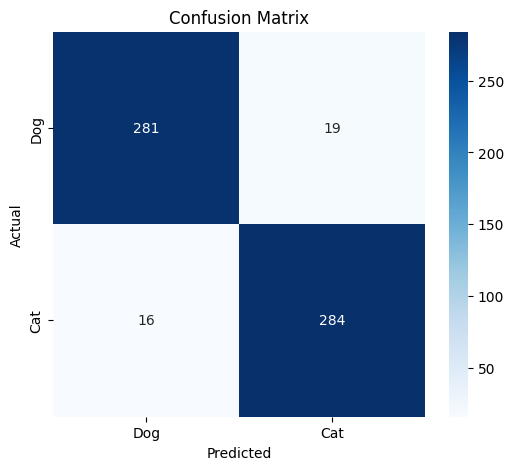

In [26]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

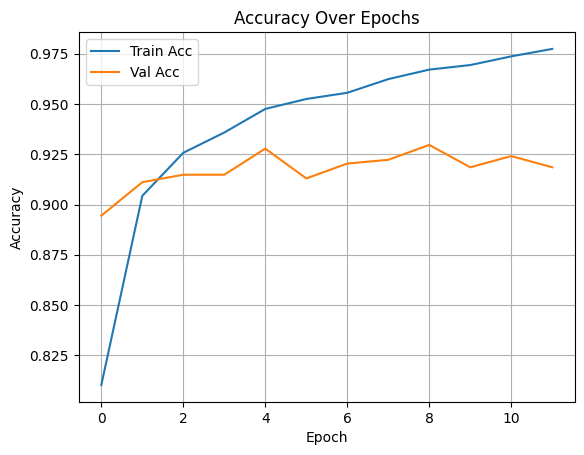

In [27]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

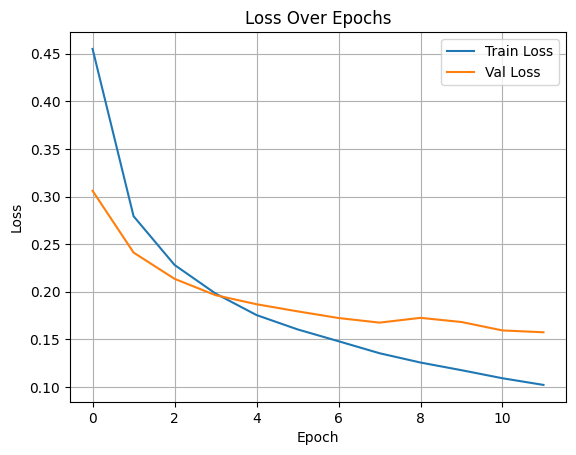

In [28]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

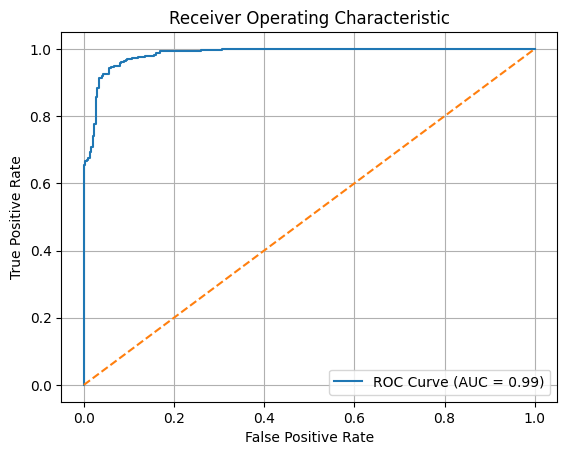

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()